<a href="https://colab.research.google.com/github/lzvtlshkvch/CE/blob/main/Copy_of_Counterfactual_SDV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import requests
from zipfile import ZipFile
from io import BytesIO

In [31]:
# ! pip install sdv

In [32]:
r = requests.get('https://archive.ics.uci.edu/static/public/573/south+german+credit+update.zip')
files = ZipFile(BytesIO(r.content))
df = pd.read_csv(files.open("SouthGermanCredit.asc"), sep = ' ')
df.head()

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


Attribute description is here https://archive.ics.uci.edu/dataset/573/south+german+credit+update

| Column name | Variable name | Content |
|---|---|---|
|laufkont|status|status of the debtor's checking account with the bank (categorical)
|laufzeit|duration|credit duration in months (quantitative)
|moral|credit_history|history of compliance with previous or concurrent credit contracts (categorical)
|verw|purpose|purpose for which the credit is needed (categorical)
|hoehe|amount|credit amount in DM (quantitative; result of monotonic transformation; actual data and type of transformation unknown)
|sparkont|savings|debtor's savings (categorical)
|beszeit|employment_duration|duration of debtor's employment with current employer (ordinal; discretized quantitative)
|rate|installment_rate|credit installments as a percentage of debtor's disposable income (ordinal; discretized quantitative)
|famges|personal_status_sex|combined information on sex and marital status; categorical; sex cannot be recovered from the variable, because male singles and female non-singles are coded with the same code (2); female widows cannot be easily classified, because the code table does not list them in any of the female categories
|buerge|other_debtors|Is there another debtor or a guarantor for the credit? (categorical)
|wohnzeit|present_residence|length of time (in years) the debtor lives in the present residence (ordinal; discretized quantitative)
|verm|property|the debtor's most valuable property, i.e. the highest possible code is used. Code 2 is used, if codes 3 or 4 are not applicable and there is a car or any other relevant property that does not fall under variable sparkont. (ordinal)
|alter|age|age in years (quantitative)
|weitkred|other_installment_plans|installment plans from providers other than the credit-giving bank (categorical)
|wohn|housing|type of housing the debtor lives in (categorical)
|bishkred|number_credits|number of credits including the current one the debtor has (or had) at this bank (ordinal, discretized quantitative); contrary to Fahrmeir and Hamerle (1984) statement, the original data values are not available.
|beruf|job|quality of debtor's job (ordinal)
|pers|people_liable|number of persons who financially depend on the debtor (i.e., are entitled to maintenance) (binary, discretized quantitative)
|telef|telephone|Is there a telephone landline registered on the debtor's name? (binary; remember that the data are from the 1970s)
|gastarb|foreign_worker|Is the debtor a foreign worker? (binary)
|kredit|credit_risk|Has the credit contract been complied with (good = 1) or not (bad = 0) ? (binary). Renamed to credit_appr = [0,1]

In [33]:
 df.rename(columns = {'laufkont' : 'status', 'laufzeit' : 'duration', 'moral' : 'credit_history', 'verw' : 'purpose',
                     'hoehe' : 'amount', 'sparkont' : 'savings', 'beszeit' : 'employment_duration',
                     'rate' : 'installment_rate', 'famges' : 'personal_status_sex', 'buerge' : 'other_debtors',
                     'wohnzeit' : 'present_residence', 'verm' : 'property', 'alter' : 'age', 'weitkred' : 'other_installment_plans',
                     'wohn' : 'housing', 'bishkred' : 'number_credits', 'beruf' : 'job', 'pers' : 'people_liable',
                     'telef' : 'telephone', 'gastarb' : 'foreign_worker', 'kredit' : 'credit_appr'}, inplace = True)
df.head()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_appr
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


In [34]:
pos = df[df.credit_appr == 1].shape[0]  # good
neg = df[df.credit_appr == 0].shape[0]  # bad
ibr = pos / neg
print(f'approved = {pos :3d} rejected = {neg :3d} imbalance ratio {ibr :.3f}')

approved = 700 rejected = 300 imbalance ratio 2.333


### Feature Analysis

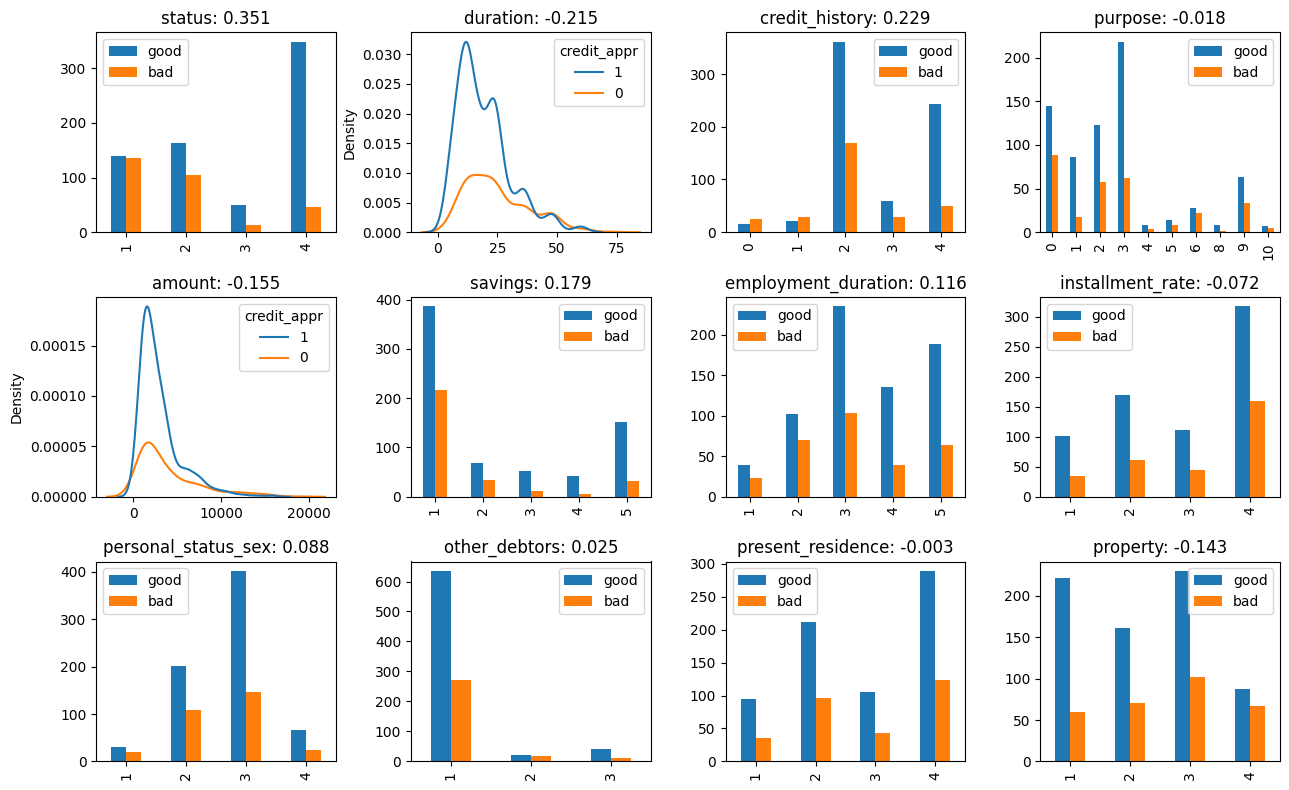

In [35]:
def plot_categorical(var, ax):
  good = df[df.credit_appr == 1][var].value_counts()
  bad  = df[df.credit_appr == 0][var].value_counts()
  pd.DataFrame({'good' : good.sort_index(), 'bad' : bad.sort_index()}).plot.bar(stacked = False, ax = ax);
  ax.set_title(var + f': {df[["credit_appr", var]].corr().iloc[0,1] :.3f}');

def plot_continuous(var, ax):
  sns.kdeplot(data = df, x = var, hue="credit_appr", hue_order = [1,0], ax = ax)
  ax.set_title(var + f': {df[["credit_appr", var]].corr().iloc[0,1] :.3f}');
  ax.set_xlabel('');

fig, ax = plt.subplots(3,4,figsize = (13,8))

plot_categorical('status', ax[0,0])  # status of debtor account - mutable (?)
plot_continuous('duration', ax[0,1]) # credit duration in months - mutable
plot_categorical('credit_history', ax[0,2]) # credit history - immutable
plot_categorical('purpose', ax[0,3])# purpose - mutable
plot_continuous('amount', ax[1,0])  # amount - mutable
plot_categorical('savings', ax[1,1]) # mutable
plot_categorical('employment_duration', ax[1,2]) # employment_duration - mutable (?)
plot_categorical('installment_rate', ax[1,3]) # installment rate - mutable
plot_categorical('personal_status_sex', ax[2,0]) # immutable
plot_categorical('other_debtors', ax[2,1]) # mutable
plot_categorical('present_residence', ax[2,2]) # mutable (?)
plot_categorical('property', ax[2,3]) # mutable (?)

fig.tight_layout();

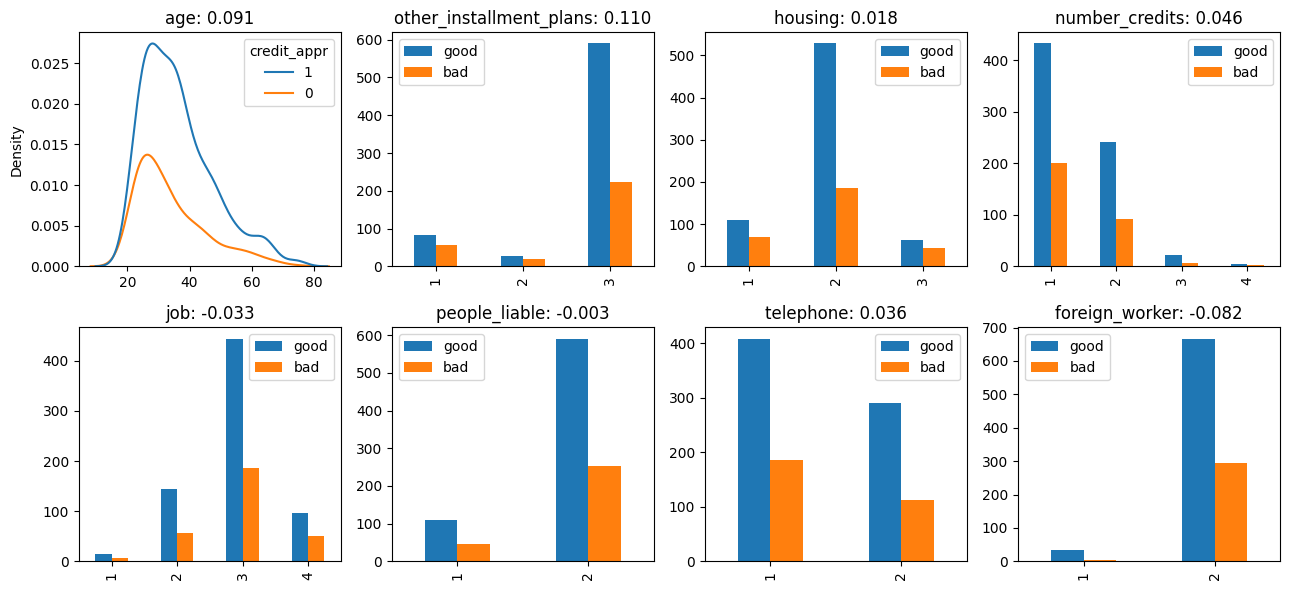

In [36]:
fig, ax = plt.subplots(2,4,figsize = (13,6))

plot_continuous('age', ax[0,0]) # immutable
plot_categorical('other_installment_plans', ax[0,1]) # mutable
plot_categorical('housing', ax[0,2]) # mutable
plot_categorical('number_credits', ax[0,3]) # mutable
plot_categorical('job', ax[1,0]) # mutable
plot_categorical('people_liable', ax[1,1]) # immutable
plot_categorical('telephone', ax[1,2]) # mutable (?)
plot_categorical('foreign_worker', ax[1,3]) # immutable
fig.tight_layout();

In [37]:
# Variables describing the credit application can be easily changed
mutable_variables_1 = ['duration', 'purpose', 'amount', 'installment_rate', 'other_debtors', 'other_installment_plans']

# Variables characterizing the debtor's current financial state, the change of which requires certain efforts
mutable_variables_2 = ['status', 'savings', 'employment_duration', 'number_credits', 'telephone']

# Immutable variables describing social state
immutable_variables = ['credit_history', 'personal_status_sex', 'present_residence',
                       'property', 'age', 'housing', 'job', 'people_liable', 'foreign_worker']

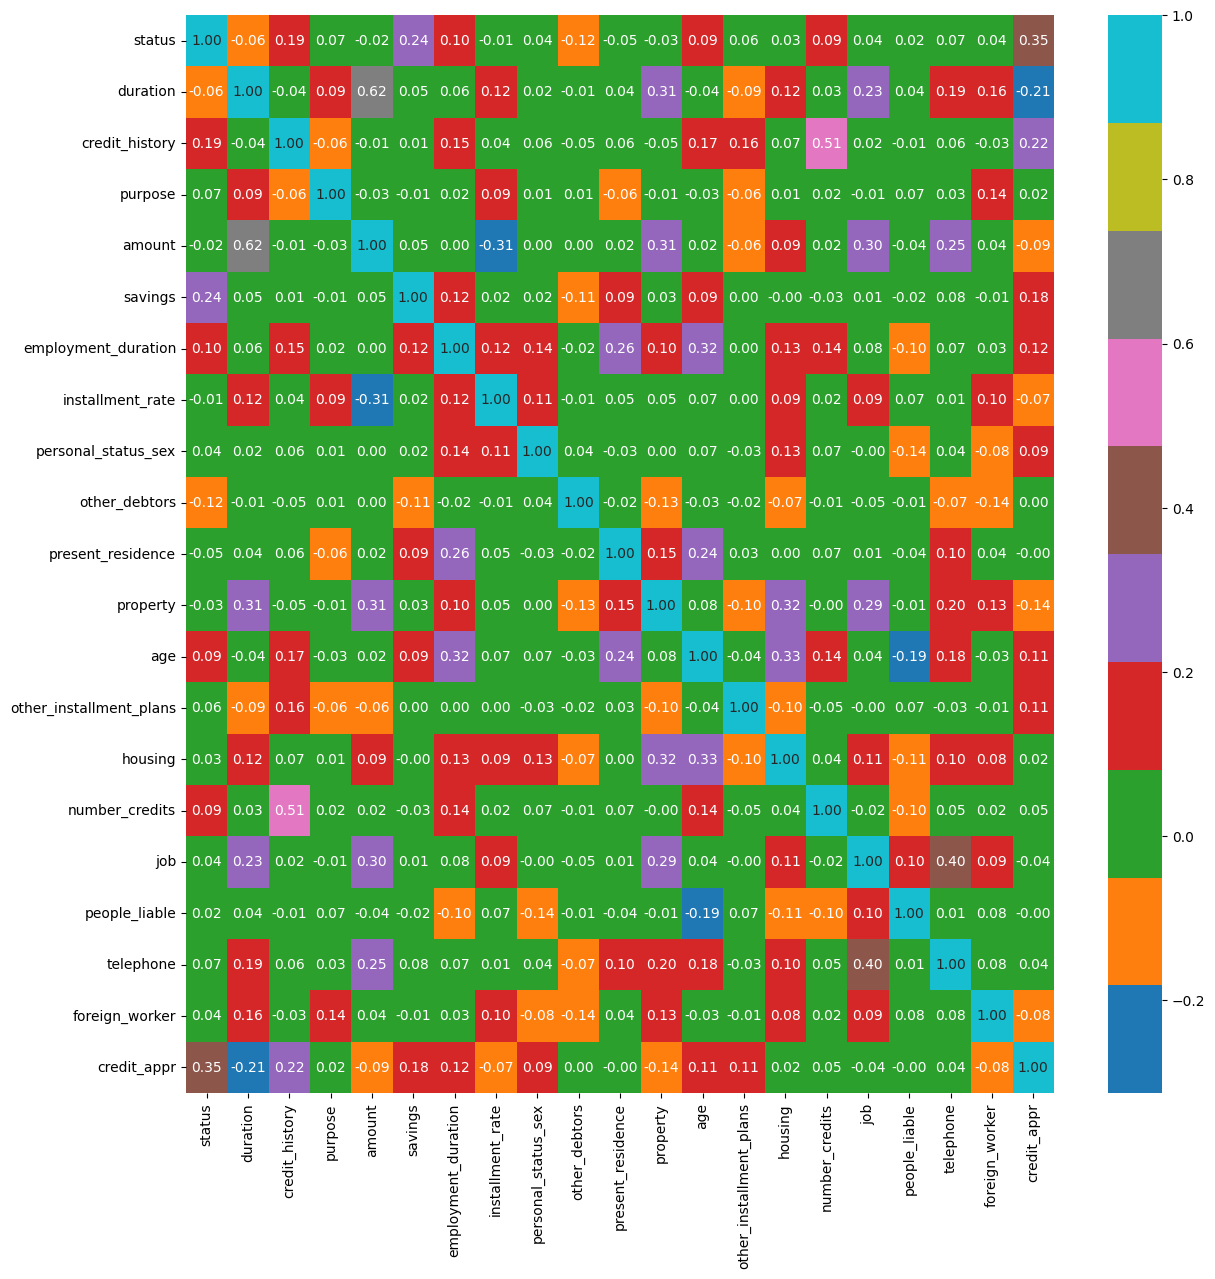

In [38]:
fig, ax = plt.subplots(1,1, figsize = (14,14))
sns.heatmap(df.corr(method = 'spearman'), annot = True, fmt = '.2f', ax = ax, cmap="tab10");

### Training Predictive Model

In [39]:
X = df.drop(['credit_appr'], axis = 1)
y = df.credit_appr

models = {'rf' : RandomForestClassifier(n_estimators = 100, max_features= 'sqrt', class_weight = 'balanced', random_state =1),
          'ab' : AdaBoostClassifier(n_estimators = 100, learning_rate = 0.15, random_state =1),
          'gb' : GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.05, random_state = 1),
          'lr' : LogisticRegression(class_weight = 'balanced', random_state = 1)}

for m in models:
  scores = cross_val_score(models[m], X, y, scoring = 'roc_auc', cv = 5, n_jobs = -1)
  print(f'{m :2s}: {scores.mean() :.3f} ({scores.std() :.3f})')

rf: 0.756 (0.078)
ab: 0.760 (0.078)
gb: 0.766 (0.070)
lr: 0.759 (0.093)


In [40]:
df


,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_appr
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,24,2,3,1987,1,3,2,3,1,...,1,21,3,1,1,2,1,1,2,0
996,1,24,2,0,2303,1,5,4,3,2,...,1,45,3,2,1,3,2,1,2,0
997,4,21,4,0,12680,5,5,4,3,1,...,4,30,3,3,1,4,2,2,2,0
998,2,12,2,3,6468,5,1,2,3,1,...,4,52,3,2,1,4,2,2,2,0


In [41]:
# Training best model

gb = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.05, random_state = 1).fit(X,y)

### Synthetic Data Vault

In [42]:
import sdv
print(sdv.__version__)

1.4.0


In [43]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [44]:
# Creating Metadata

from sdv.metadata import SingleTableMetadata

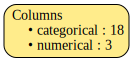

In [45]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data = df)

# categorical attributes
for c in ['status', 'credit_history', 'purpose', 'savings','employment_duration', 'installment_rate', 'personal_status_sex',
          'other_debtors', 'present_residence', 'property', 'other_installment_plans', 'housing', 'number_credits', 'job',
          'people_liable', 'telephone', 'foreign_worker', 'credit_appr']:
  metadata.update_column(column_name = c, sdtype = 'categorical')

# boolean attributes
# for c in ['people_liable', 'telephone', 'foreign_worker', 'credit_appr']:
#  metadata.update_column(column_name = c, sdtype='boolean')

# numerical attributes
for c in ['duration','amount','age']:
  metadata.update_column(column_name = c, sdtype='numerical', computer_representation='Int32')

metadata.visualize(
    show_table_details='summarized',
    output_filepath='my_metadata.png'
)

In [46]:
from sdv.lite import SingleTablePreset

synthesizer = SingleTablePreset(metadata, name = 'FAST_ML')
synthesizer.fit(df)

#synthetic_data = synthesizer.sample(num_rows = 5)

In [47]:
# sampling with immutable features

n = 10 # number of samples generated

def immutable_data(example):
  d = {}
  for c in immutable_variables + mutable_variables_2:   # including difficult to mutate features too
    d[c] = [example[c]]
  d['credit_appr'] = [1]
  return pd.DataFrame(data = d)

example = df[df.credit_appr == 0].iloc[0]

reference_data = immutable_data(example)

synthetic_data = synthesizer.sample_remaining_columns(known_columns = reference_data)

for i in range(0,n - 1):
  synthetic_data = pd.concat([synthetic_data, synthesizer.sample_remaining_columns(known_columns=reference_data)])

Sampling remaining columns: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]/usr/local/lib/python3.10/dist-packages/sdv/single_table/base.py:694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_rows[COND_IDX] = dataframe[COND_IDX].to_numpy()[:len(sampled_rows)]
Sampling remaining columns: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


In [48]:
# check generated values on the base of best predictive model

y_pred = gb.predict(synthetic_data.drop(['credit_appr'], axis = 1))
print(f'Number of good predictions: {y_pred[y_pred == 1].sum() :2d} from {len(y_pred) :2d}')

Number of good predictions:  7 from 10


In [49]:
sd = synthetic_data.T
pd.concat([sd, example], axis = 1)

,0,0,0,0,0,0,0,0,0,0,22
status,2,2,2,2,2,2,2,2,2,2,2
duration,32,31,29,22,39,15,4,28,14,19,36
credit_history,2,2,2,2,2,2,2,2,2,2,2
purpose,3,0,2,10,1,3,0,3,0,2,5
amount,5475,706,6570,2801,10303,1345,4283,4029,3065,250,2384
savings,1,1,1,1,1,1,1,1,1,1,1
employment_duration,2,2,2,2,2,2,2,2,2,2,2
installment_rate,3,4,2,4,2,2,2,4,2,4,4
personal_status_sex,3,3,3,3,3,3,3,3,3,3,3
other_debtors,1,1,1,1,1,1,1,1,1,1,1


TODO:

- предиктивную модель (pm) с очень высокой точностью построить (ROC_AUC > 0.9), см. что там с confusion_matrix
- найти метрики для counterfactual exaplanation (CE)
- включить количество верных предсказаний pm в метрики
- сравнить все сэмплеры из sdv (как минимум, копулы и VAE, GAN под вопросом)
- сравнить с резльтатами dice
- искать / реализовать другие алгоритмы CE
- сделать сравнение всех алгоритмов на нескольких датасетах, см. что в литературе

In [50]:
from sdv.single_table import GaussianCopulaSynthesizer
synthesizer = GaussianCopulaSynthesizer(metadata,
                                        enforce_min_max_values = True,
                                        enforce_rounding = True,
#                                        numerical_distributions = None,
                                        default_distribution = 'beta'
                                        )
synthesizer.fit(df)

In [51]:
synthetic_data = synthesizer.sample(num_rows = 5)
synthetic_data

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_appr
0,4,24,2,9,2549,5,1,4,3,1,...,3,41,3,3,1,1,2,1,2,1
1,1,10,4,3,1500,4,5,4,3,1,...,1,39,3,2,2,2,2,1,2,1
2,4,7,4,3,521,2,4,4,3,1,...,3,54,3,1,2,3,2,2,2,1
3,4,12,4,1,3565,5,5,2,4,1,...,3,46,1,3,1,4,2,1,2,1
4,4,8,4,0,763,2,3,3,2,1,...,1,29,3,2,1,3,2,1,2,0


In [52]:
# synthesizer.get_learned_distributions()

In [53]:
from sdv.single_table import TVAESynthesizer

synthesizer = TVAESynthesizer(metadata, enforce_min_max_values = True, enforce_rounding = True, epochs = 50, cuda = True)
synthesizer.fit(df)

synthetic_data = synthesizer.sample(num_rows=5)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [54]:
synthetic_data

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_appr
0,4,10,2,3,1981,1,3,4,3,1,...,3,23,3,2,1,3,2,1,2,1
1,4,13,2,3,1566,1,3,4,3,1,...,3,31,3,2,1,3,2,1,2,1
2,4,10,2,3,1396,1,3,4,3,1,...,3,24,3,2,1,3,2,1,2,1
3,4,12,2,3,1925,1,3,4,3,1,...,3,25,3,2,1,3,2,1,2,1
4,4,10,2,3,1774,1,3,4,3,1,...,3,25,3,2,1,3,2,1,2,1
